In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go


import sys
import os

sys.path.append(os.path.abspath('../src'))
import utils as util

# Definindo tema e cores
cores_personalizadas = [util.barra_azul, util.barra_vermelha]

df = pd.read_csv('../data/databaseElisa.csv', sep=';', decimal=',', thousands='.', 
                 index_col=None)

df.tail()


,data,fazenda,almoco,janta,cafe,lanche,vlrAlmoco,vlrJanta,vlrCafe,vlrLanche,total
3065,11/05/2025,Silo,5,6,5,0,20.0,20.0,8.5,8.5,262.5
3066,12/05/2025,Santa Elisa,5,1,6,1,20.0,20.0,8.5,8.5,179.5
3067,12/05/2025,Silo,12,6,14,0,20.0,20.0,8.5,8.5,479.0
3068,13/05/2025,Santa Elisa,9,2,6,1,20.0,20.0,8.5,8.5,279.5
3069,13/05/2025,Silo,12,6,14,0,20.0,20.0,8.5,8.5,479.0


In [2]:

df['data'] = pd.to_datetime(df['data'], dayfirst=True, errors='coerce')

data_inicio = pd.Timestamp('2025-02-01')


df_filtrado = df[df['data'] >= data_inicio].copy()


In [3]:
df_filtrado.head()

,data,fazenda,almoco,janta,cafe,lanche,vlrAlmoco,vlrJanta,vlrCafe,vlrLanche,total
2984,2025-04-01,Santa Elisa,6,1,0,0,20.0,20.0,8.5,8.5,140.0
2985,2025-04-01,Silo,25,7,25,2,20.0,20.0,8.5,8.5,869.5
2986,2025-04-02,Santa Elisa,7,1,0,0,20.0,20.0,8.5,8.5,160.0
2987,2025-04-02,Silo,21,8,25,4,20.0,20.0,8.5,8.5,826.5
2988,2025-04-03,Santa Elisa,6,1,0,0,20.0,20.0,8.5,8.5,140.0


In [4]:
df_filtrado.tail()

,data,fazenda,almoco,janta,cafe,lanche,vlrAlmoco,vlrJanta,vlrCafe,vlrLanche,total
3065,2025-05-11,Silo,5,6,5,0,20.0,20.0,8.5,8.5,262.5
3066,2025-05-12,Santa Elisa,5,1,6,1,20.0,20.0,8.5,8.5,179.5
3067,2025-05-12,Silo,12,6,14,0,20.0,20.0,8.5,8.5,479.0
3068,2025-05-13,Santa Elisa,9,2,6,1,20.0,20.0,8.5,8.5,279.5
3069,2025-05-13,Silo,12,6,14,0,20.0,20.0,8.5,8.5,479.0


In [5]:
util.generate_metadata(df_filtrado)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,data,datetime64[ns],0,0.0,43
1,almoco,int64,0,0.0,25
2,janta,int64,0,0.0,9
3,cafe,int64,0,0.0,15
4,lanche,int64,0,0.0,6
5,vlrAlmoco,float64,0,0.0,1
6,vlrJanta,float64,0,0.0,1
7,vlrCafe,float64,0,0.0,1
8,vlrLanche,float64,0,0.0,1
9,total,float64,0,0.0,64


In [6]:
# Descrição estatística das colunas numéricasdf
cols_to_describe = ['almoco', 'janta', 'cafe', 'lanche', 'vlrAlmoco', 'vlrJanta', 'vlrCafe', 'vlrLanche', 'total']

df_filtrado[cols_to_describe].describe()

,almoco,janta,cafe,lanche,vlrAlmoco,vlrJanta,vlrCafe,vlrLanche,total
count,86.000000,86.000000,86.000000,86.000000,86.0,86.0,86.0,86.0,86.000000
mean,10.023256,3.720930,10.732558,0.383721,20.0,20.0,8.5,8.5,369.372093
std,6.444289,2.742481,9.927294,1.294046,0.0,0.0,0.0,0.0,253.641644
min,0.000000,0.000000,0.000000,0.000000,20.0,20.0,8.5,8.5,0.000000
25%,5.000000,1.000000,0.000000,0.000000,20.0,20.0,8.5,8.5,160.000000
50%,9.000000,4.000000,8.500000,0.000000,20.0,20.0,8.5,8.5,342.000000
75%,14.750000,6.000000,20.000000,0.000000,20.0,20.0,8.5,8.5,590.000000
max,26.000000,8.000000,28.000000,10.000000,20.0,20.0,8.5,8.5,901.000000


In [7]:
util.lista_valores_unicos(df_filtrado, 'fazenda')

,Coluna,Categoria,Cardinalidade,Porcentagem
0,fazenda,Santa Elisa,43,50.00%
1,fazenda,Silo,43,50.00%


In [8]:
df_filtrado.columns = df_filtrado.columns.str.strip().str.lower()

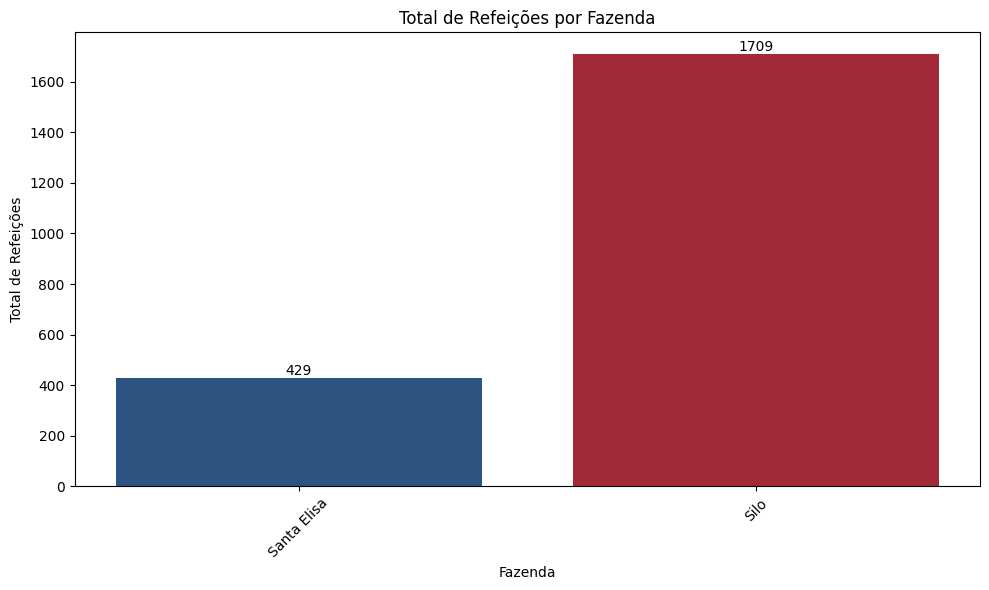

In [9]:
# 002. Quantidade total de refeições por fazenda
qtd_cols = ['almoco', 'janta', 'lanche', 'cafe']
df_qtd_fazenda = df_filtrado.groupby('fazenda')[qtd_cols].sum().reset_index()
df_qtd_fazenda['total_refeicoes'] = df_qtd_fazenda[qtd_cols].sum(axis=1)

# Criar lista de cores alternando conforme número de fazendas
cores = [cores_personalizadas[i % len(cores_personalizadas)] for i in range(len(df_qtd_fazenda))]

# Plotar gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(df_qtd_fazenda['fazenda'], df_qtd_fazenda['total_refeicoes'], color=cores)

# Adicionar rótulos nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

plt.title('Total de Refeições por Fazenda')
plt.xlabel('Fazenda')
plt.ylabel('Total de Refeições')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

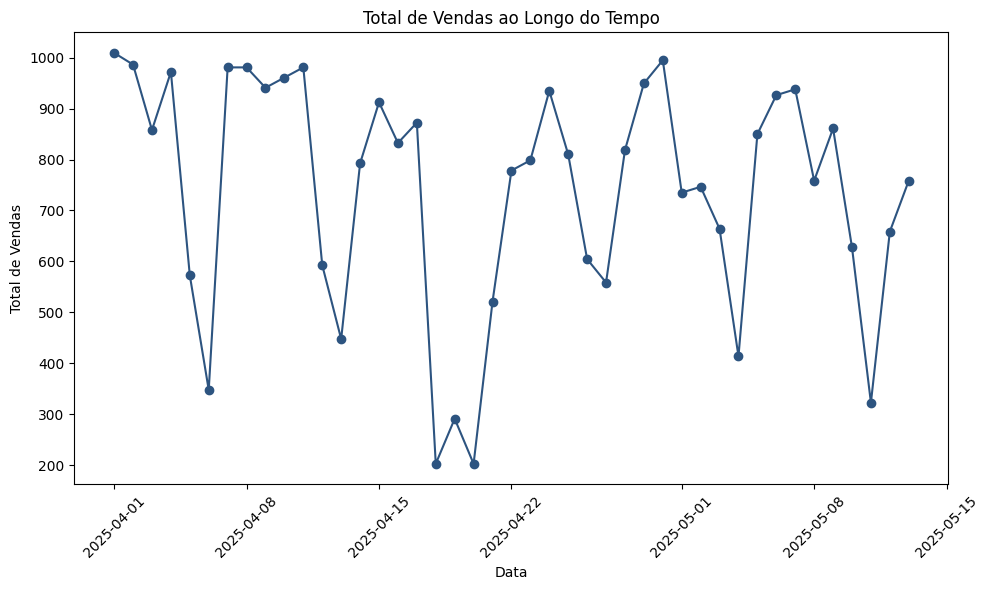

In [10]:
# 003. Evolução temporal do total de vendas
import matplotlib.pyplot as plt

df_data_total = df_filtrado.groupby('data')['total'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_data_total['data'], df_data_total['total'], marker='o', color=util.barra_azul)
plt.title('Total de Vendas ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


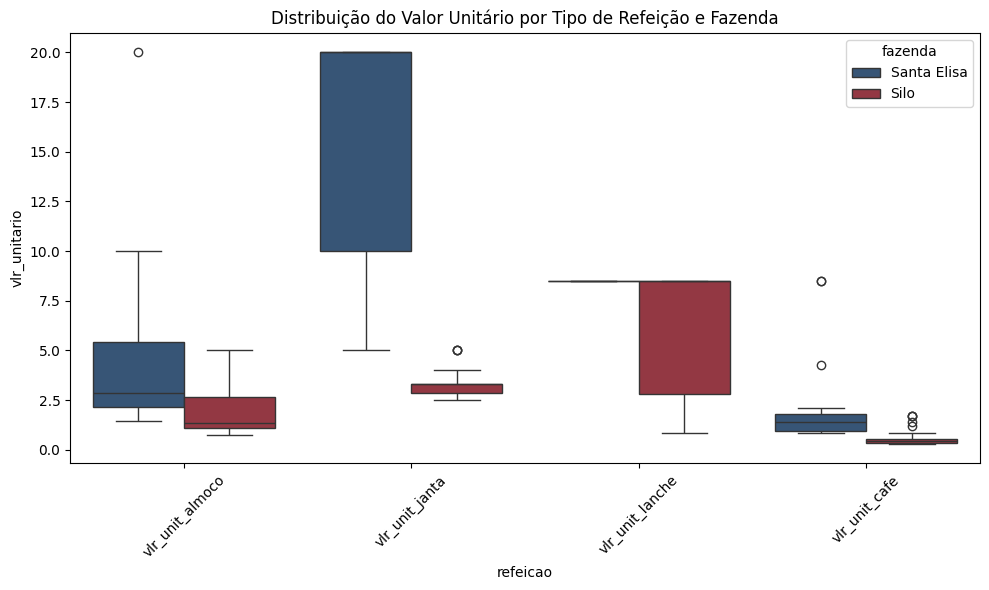

In [11]:
# 004. Comparativo de ticket médio (valor unitário) entre fazendas
df_filtrado['vlr_unit_almoco'] = df_filtrado['vlralmoco'] / df_filtrado['almoco'].replace(0, pd.NA)
df_filtrado['vlr_unit_janta'] = df_filtrado['vlrjanta'] / df_filtrado['janta'].replace(0, pd.NA)
df_filtrado['vlr_unit_lanche'] = df_filtrado['vlrlanche'] / df_filtrado['lanche'].replace(0, pd.NA)
df_filtrado['vlr_unit_cafe'] = df_filtrado['vlrcafe'] / df_filtrado['cafe'].replace(0, pd.NA)

df_melt = df_filtrado.melt(id_vars=['fazenda'], value_vars=[
    'vlr_unit_almoco', 'vlr_unit_janta', 'vlr_unit_lanche', 'vlr_unit_cafe'],
    var_name='refeicao', value_name='vlr_unitario')

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melt, x='refeicao', y='vlr_unitario', hue='fazenda',
            palette=[util.barra_azul, util.barra_vermelha])
plt.title('Distribuição do Valor Unitário por Tipo de Refeição e Fazenda')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


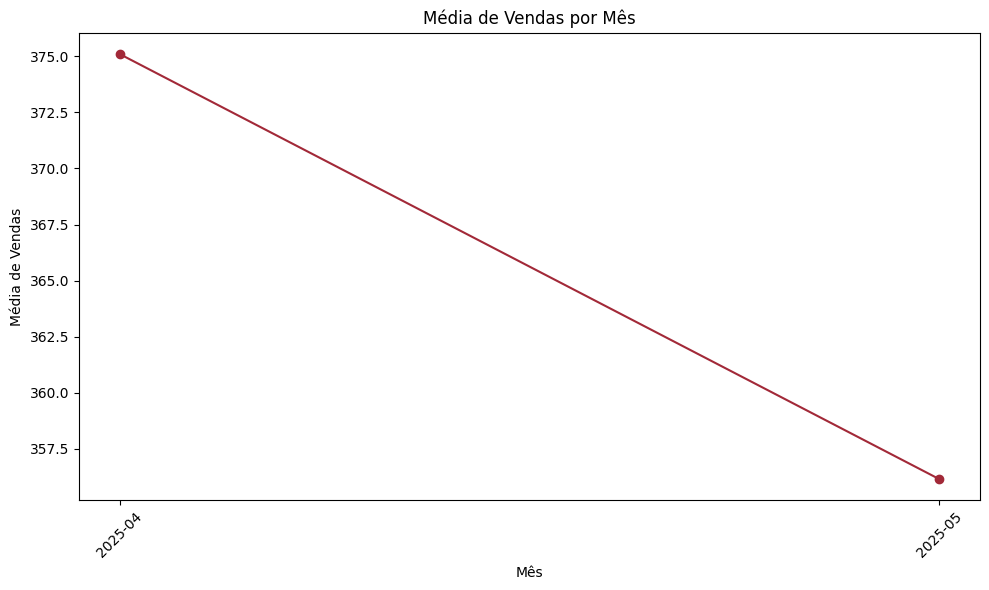

In [12]:
# 005. Análise sazonal: média de vendas por mês
df_filtrado['data'] = pd.to_datetime(df_filtrado['data'], dayfirst=True, errors='coerce')
df_filtrado['mes'] = df_filtrado['data'].dt.to_period('M').astype(str)
df_mes = df_filtrado.groupby('mes')['total'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_mes['mes'], df_mes['total'], marker='o', color=util.barra_vermelha)
plt.title('Média de Vendas por Mês')
plt.xlabel('Mês')
plt.ylabel('Média de Vendas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


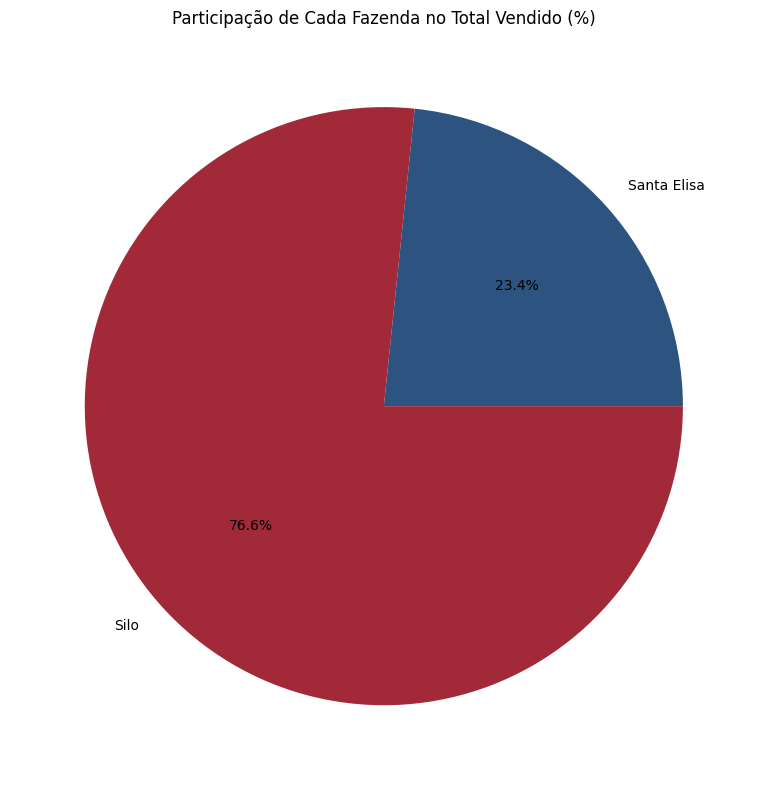

In [13]:
# 006. Análise percentual de participação das fazendas no total vendido
df_total_faz = df_filtrado.groupby('fazenda')['total'].sum().reset_index()
df_total_faz['percentual'] = df_total_faz['total'] / df_total_faz['total'].sum() * 100

plt.figure(figsize=(8, 8))
plt.pie(df_total_faz['percentual'], labels=df_total_faz['fazenda'],
        autopct='%1.1f%%', colors=[util.barra_azul, util.barra_vermelha])
plt.title('Participação de Cada Fazenda no Total Vendido (%)')
plt.tight_layout()
plt.show()


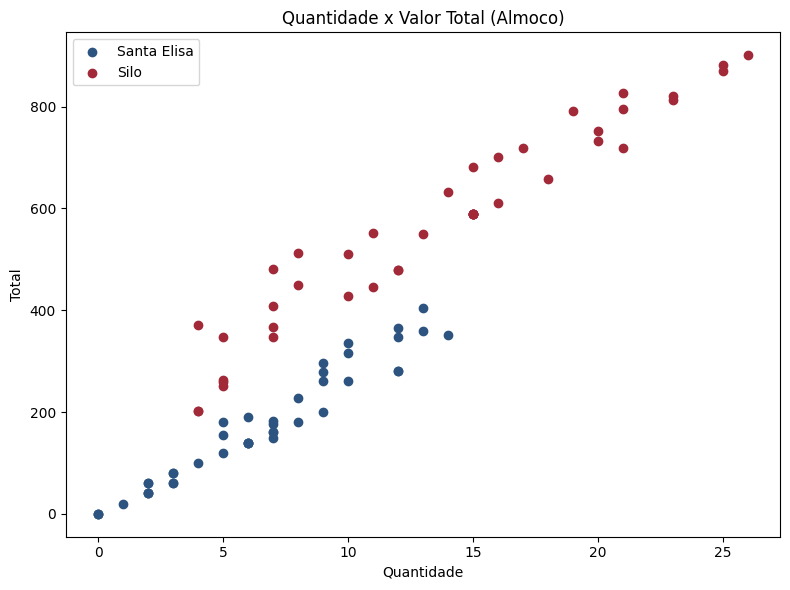

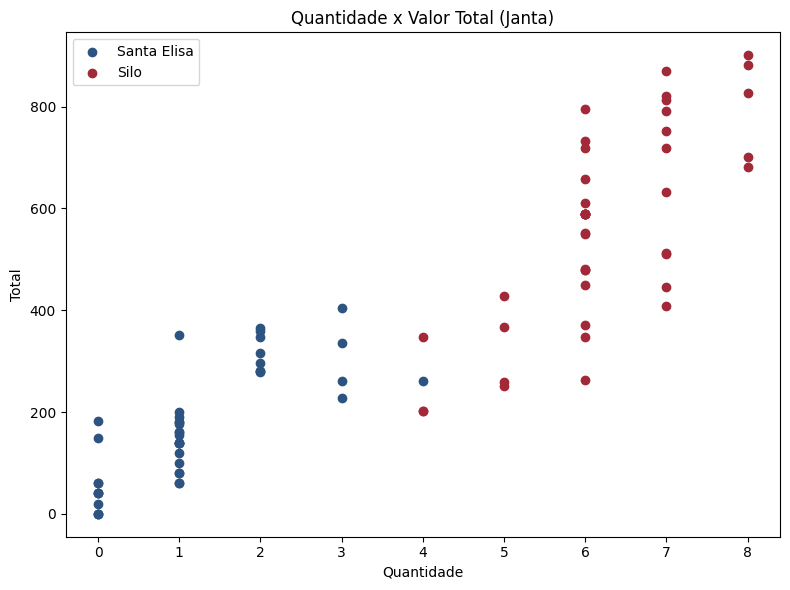

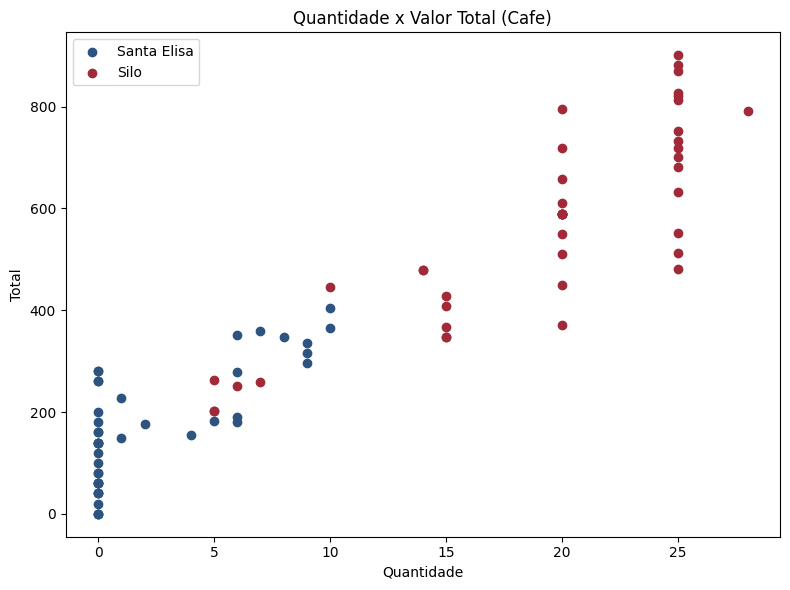

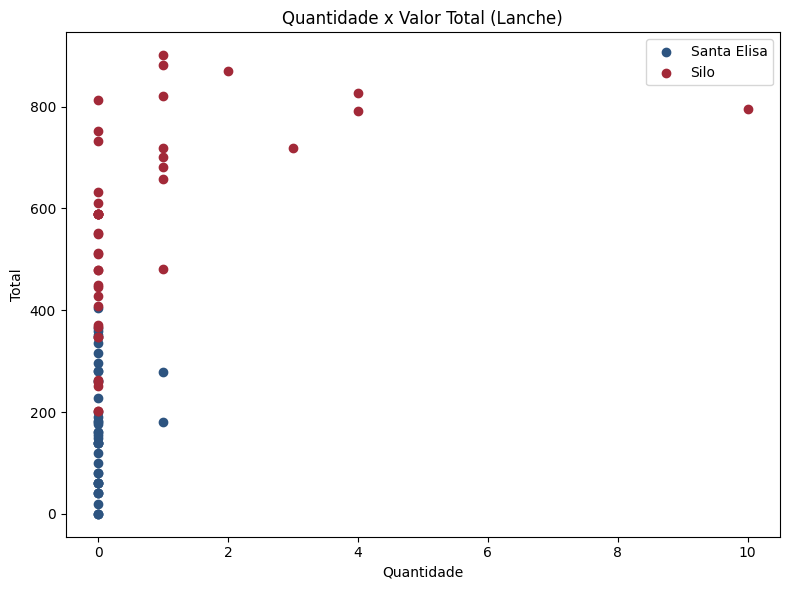

In [14]:
# 007. Correlação entre quantidade e valor total das refeições
for refeicao in ['almoco', 'janta', 'cafe', 'lanche']:
    plt.figure(figsize=(8, 6))
    for i, faz in enumerate(df_filtrado['fazenda'].unique()):
        subset = df_filtrado[df_filtrado['fazenda'] == faz]
        plt.scatter(subset[refeicao], subset['total'],
                    label=faz, color=[util.barra_azul, util.barra_vermelha][i % 2])
    plt.title(f'Quantidade x Valor Total ({refeicao.capitalize()})')
    plt.xlabel('Quantidade')
    plt.ylabel('Total')
    plt.legend()
    plt.tight_layout()
    plt.show()


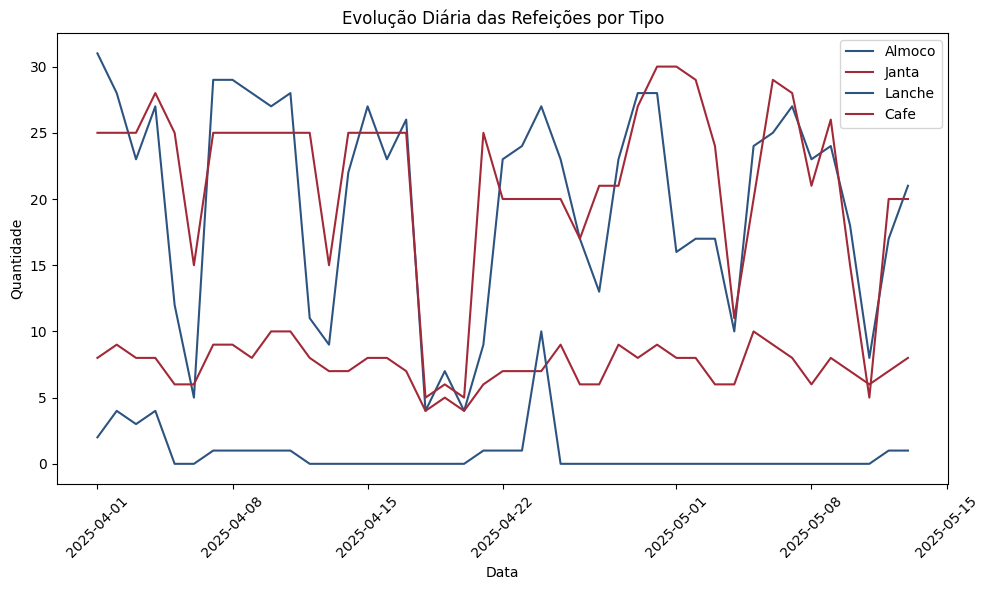

In [15]:
# 008. Evolução de cada tipo de refeição ao longo do tempo
df_refeicoes_tempo = df_filtrado.groupby('data')[qtd_cols].sum().reset_index()

plt.figure(figsize=(10, 6))
for i, col in enumerate(qtd_cols):
    plt.plot(df_refeicoes_tempo['data'], df_refeicoes_tempo[col],
             label=col.capitalize(), color=[util.barra_azul, util.barra_vermelha][i % 2])
plt.title('Evolução Diária das Refeições por Tipo')
plt.xlabel('Data')
plt.ylabel('Quantidade')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


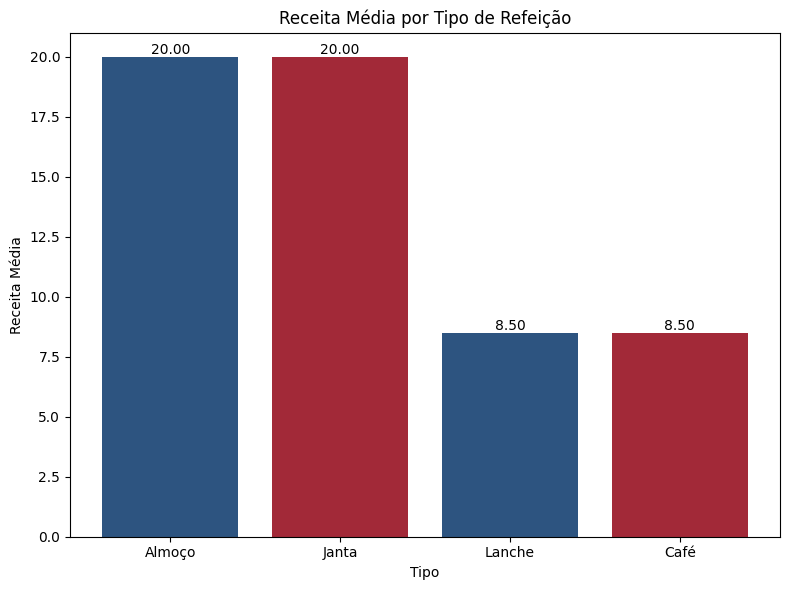

In [16]:
# 009. Receita média por tipo de refeição
df_receita_media = pd.DataFrame({
    'Tipo': ['Almoço', 'Janta', 'Lanche', 'Café'],
    'Receita Média': [
        df_filtrado['vlralmoco'].mean(),
        df_filtrado['vlrjanta'].mean(),
        df_filtrado['vlrlanche'].mean(),
        df_filtrado['vlrcafe'].mean()
    ]
})

plt.figure(figsize=(8, 6))
bars = plt.bar(df_receita_media['Tipo'], df_receita_media['Receita Média'],
               color=[util.barra_azul, util.barra_vermelha] * 2)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}',
             ha='center', va='bottom')
plt.title('Receita Média por Tipo de Refeição')
plt.xlabel('Tipo')
plt.ylabel('Receita Média')
plt.tight_layout()
plt.show()

/tmp/ipykernel_6481/3575590781.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtrado, x='fazenda', y='total',


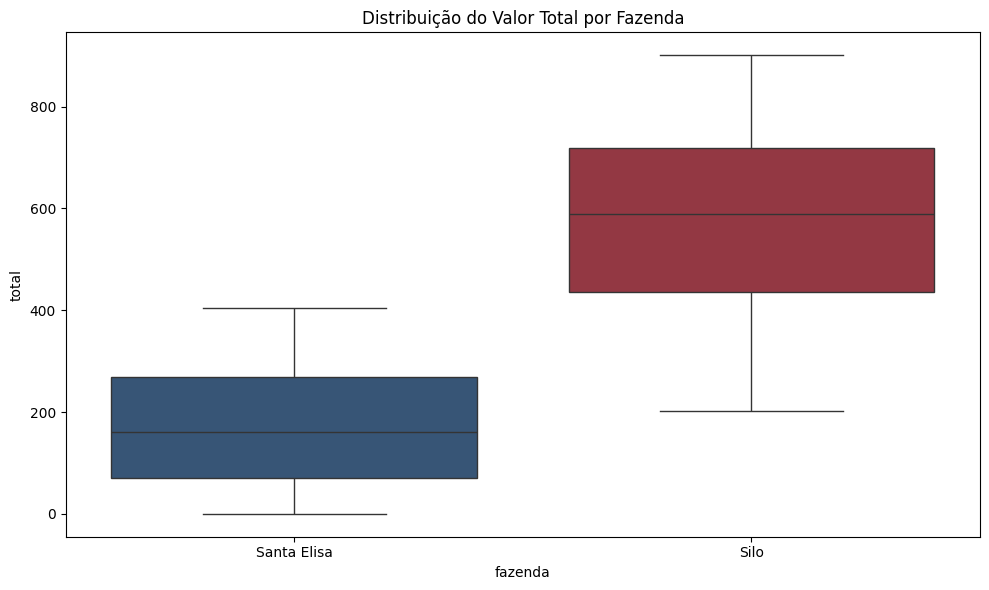

In [17]:
# 010. Análise de outliers no valor total por fazenda
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtrado, x='fazenda', y='total',
            palette=[util.barra_azul, util.barra_vermelha])
plt.title('Distribuição do Valor Total por Fazenda')
plt.tight_layout()
plt.show()


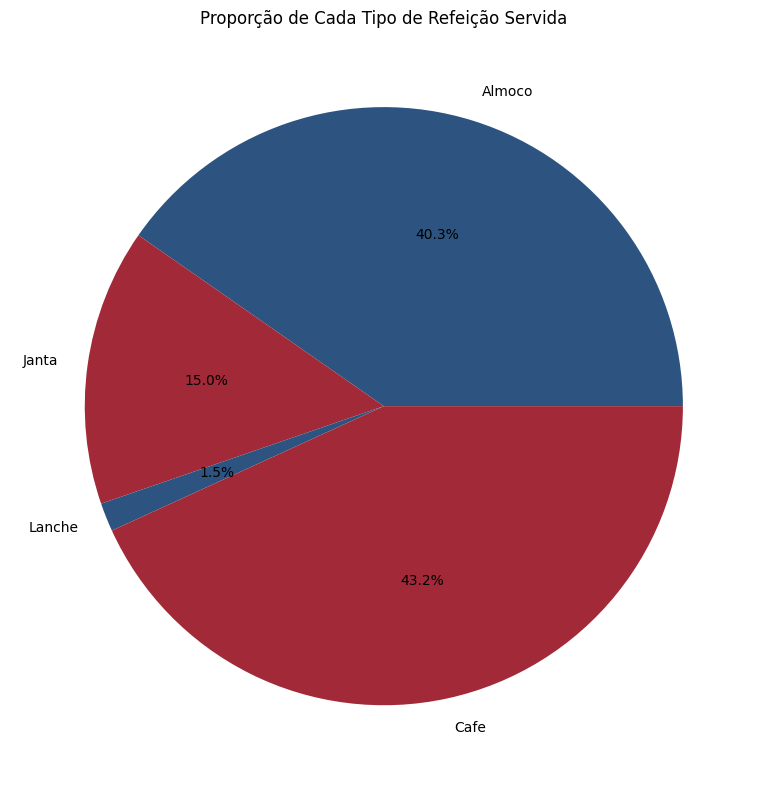

In [18]:
# 011. Proporção de cada tipo de refeição no total servido
df_total_refeicoes = df_filtrado[qtd_cols].sum().reset_index()
df_total_refeicoes.columns = ['Tipo', 'Total Servido']
df_total_refeicoes['Tipo'] = df_total_refeicoes['Tipo'].str.capitalize()

plt.figure(figsize=(8, 8))
plt.pie(df_total_refeicoes['Total Servido'], labels=df_total_refeicoes['Tipo'],
        autopct='%1.1f%%', colors=[util.barra_azul, util.barra_vermelha]*2)
plt.title('Proporção de Cada Tipo de Refeição Servida')
plt.tight_layout()
plt.show()


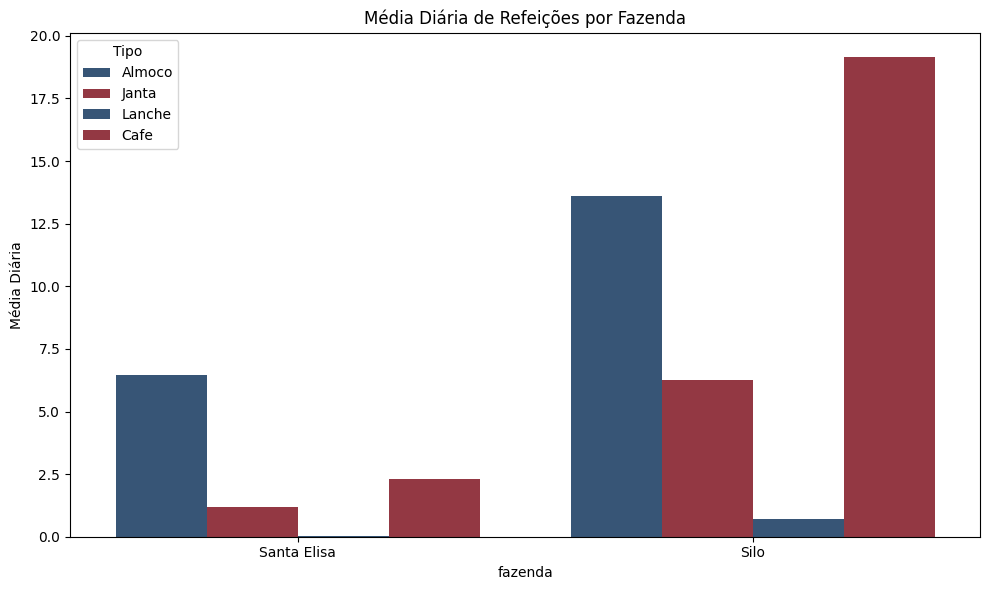

In [19]:
# 012. Média diária de refeições por fazenda
df_media_diaria = df_filtrado.groupby('fazenda')[qtd_cols].mean().reset_index()
df_media_diaria = df_media_diaria.melt(id_vars='fazenda', var_name='Tipo', value_name='Média Diária')
df_media_diaria['Tipo'] = df_media_diaria['Tipo'].str.capitalize()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_media_diaria, x='fazenda', y='Média Diária', hue='Tipo',
            palette=[util.barra_azul, util.barra_vermelha]*2)
plt.title('Média Diária de Refeições por Fazenda')
plt.tight_layout()
plt.show()


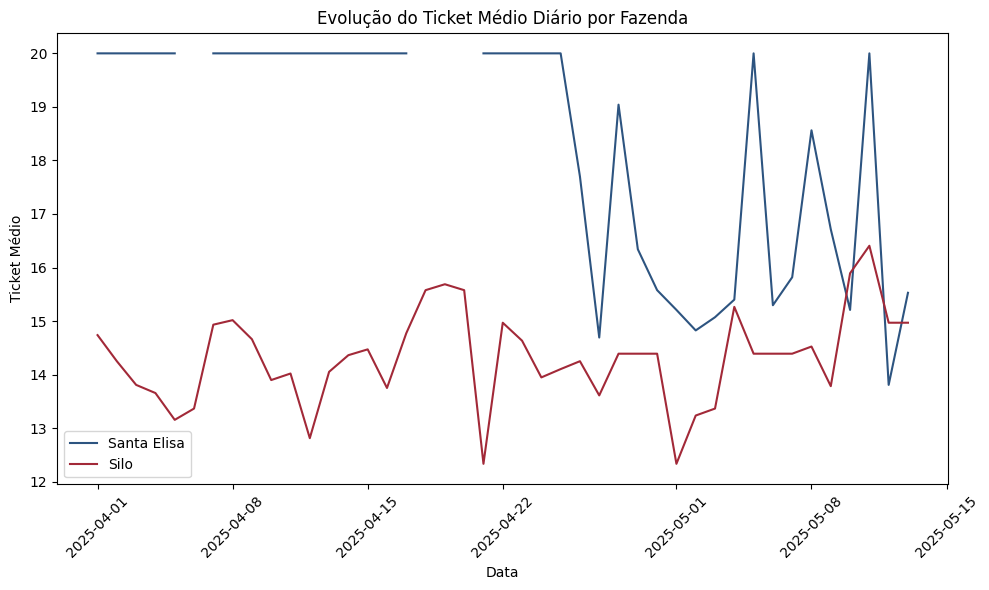

In [20]:
# 013. Evolução do ticket médio diário por fazenda
df_filtrado['ticket_medio'] = df_filtrado['total'] / (df_filtrado[qtd_cols].sum(axis=1).replace(0, pd.NA))
df_ticket_diario = df_filtrado.groupby(['data', 'fazenda'])['ticket_medio'].mean().reset_index()

plt.figure(figsize=(10, 6))
for i, faz in enumerate(df_ticket_diario['fazenda'].unique()):
    subset = df_ticket_diario[df_ticket_diario['fazenda'] == faz]
    plt.plot(subset['data'], subset['ticket_medio'], label=faz,
             color=[util.barra_azul, util.barra_vermelha][i % 2])
plt.title('Evolução do Ticket Médio Diário por Fazenda')
plt.xlabel('Data')
plt.ylabel('Ticket Médio')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



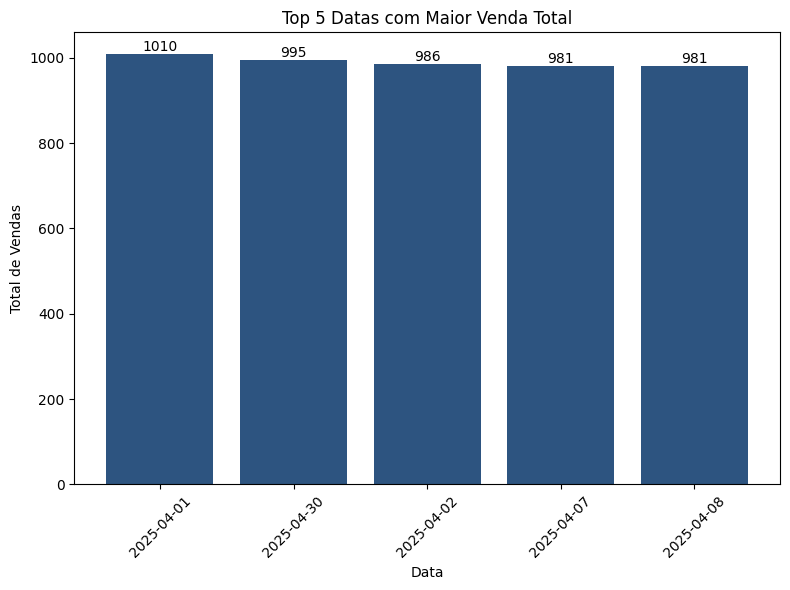

In [21]:
# 014. Top 5 datas com maior venda total
df_top_vendas = df_filtrado.groupby('data')['total'].sum().nlargest(5).reset_index()

plt.figure(figsize=(8, 6))
bars = plt.bar(df_top_vendas['data'].astype(str), df_top_vendas['total'], color=util.barra_azul)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.0f}',
             ha='center', va='bottom')
plt.title('Top 5 Datas com Maior Venda Total')
plt.xlabel('Data')
plt.ylabel('Total de Vendas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


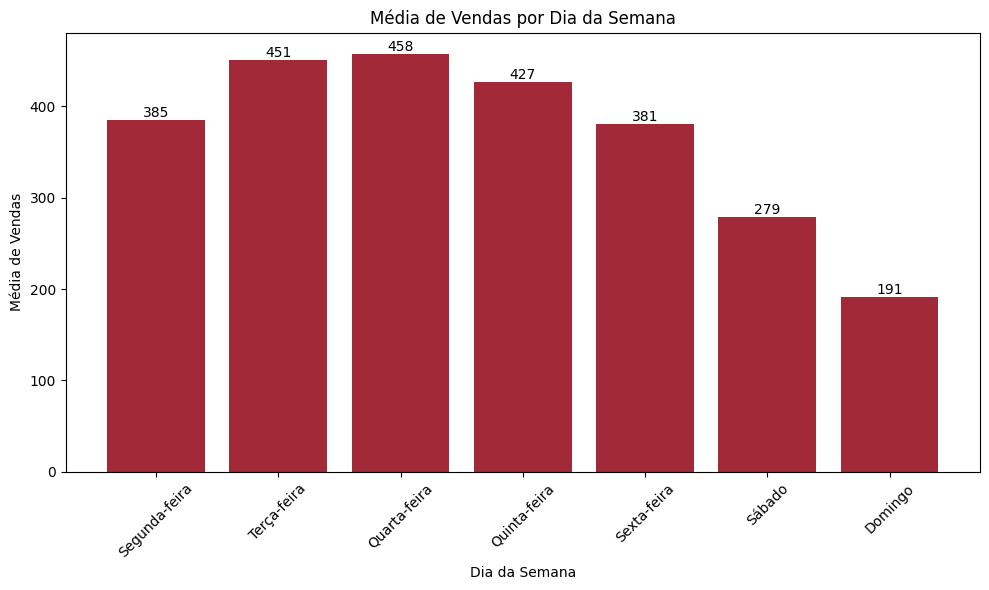

In [22]:
# 015. Dias da semana com maior venda média
df_filtrado['dia_semana'] = df_filtrado['data'].dt.day_name()
df_venda_dia = df_filtrado.groupby('dia_semana')['total'].mean().reset_index()
df_venda_dia['dia_semana'] = df_venda_dia['dia_semana'].map(util.traducao_dias)

ordem_dias_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
df_venda_dia['dia_semana'] = pd.Categorical(df_venda_dia['dia_semana'], categories=ordem_dias_pt, ordered=True)
df_venda_dia = df_venda_dia.sort_values('dia_semana')

plt.figure(figsize=(10, 6))
bars = plt.bar(df_venda_dia['dia_semana'], df_venda_dia['total'], color=util.barra_vermelha)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.0f}',
             ha='center', va='bottom')
plt.title('Média de Vendas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Média de Vendas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


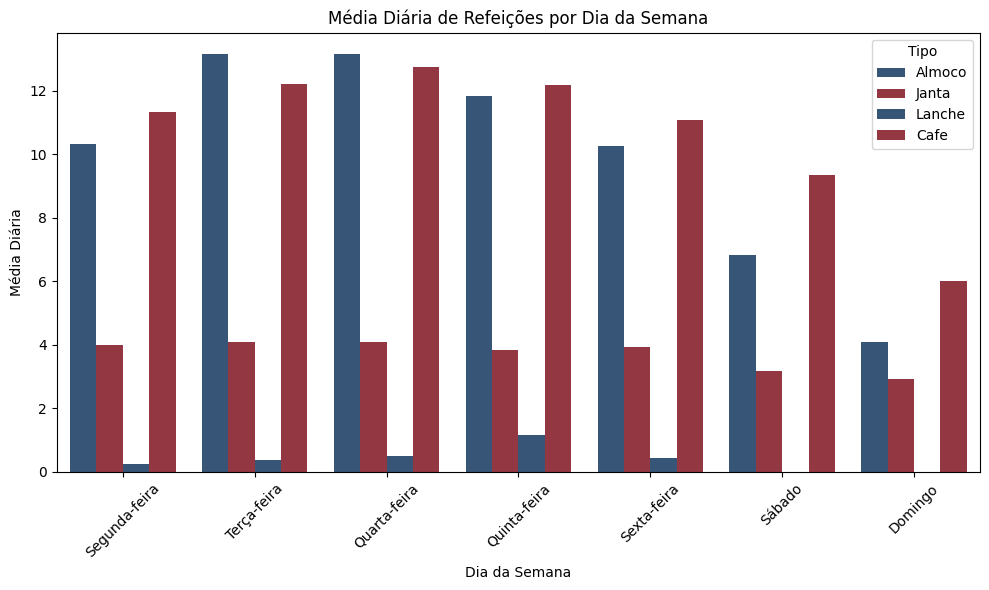

In [23]:
# 016. Média diária de quantidade refeições por dia da semana
qtd_cols = ['almoco', 'janta', 'lanche', 'cafe']
df_filtrado['dia_semana'] = df_filtrado['data'].dt.day_name()
df_media_semana = df_filtrado.groupby('dia_semana')[qtd_cols].mean().reset_index()
df_media_semana['dia_semana'] = df_media_semana['dia_semana'].map(util.traducao_dias)

ordem_dias_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
df_media_semana['dia_semana'] = pd.Categorical(df_media_semana['dia_semana'], categories=ordem_dias_pt, ordered=True)
df_media_semana = df_media_semana.sort_values('dia_semana')

df_melted = df_media_semana.melt(id_vars='dia_semana', var_name='Tipo', value_name='Média Diária')
df_melted['Tipo'] = df_melted['Tipo'].str.capitalize()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='dia_semana', y='Média Diária', hue='Tipo',
            palette=[util.barra_azul, util.barra_vermelha]*2)
plt.title('Média Diária de Refeições por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Média Diária')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

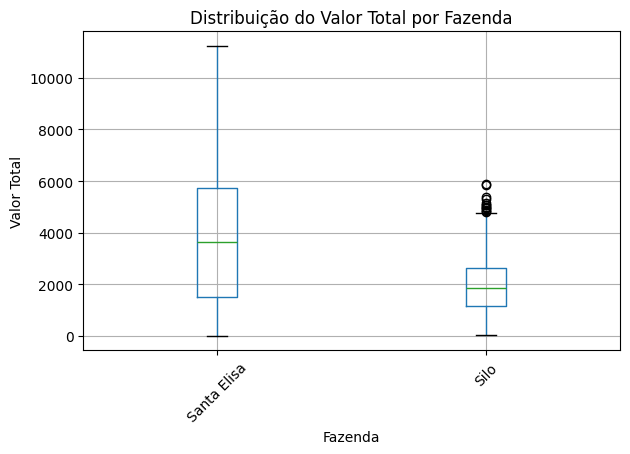

In [24]:
# 017. Boxplot do valor total por fazenda
plt.figure(figsize=(10, 6))
df.boxplot(column='total', by='fazenda')
plt.title('Distribuição do Valor Total por Fazenda')
plt.suptitle('')
plt.xlabel('Fazenda')
plt.ylabel('Valor Total')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


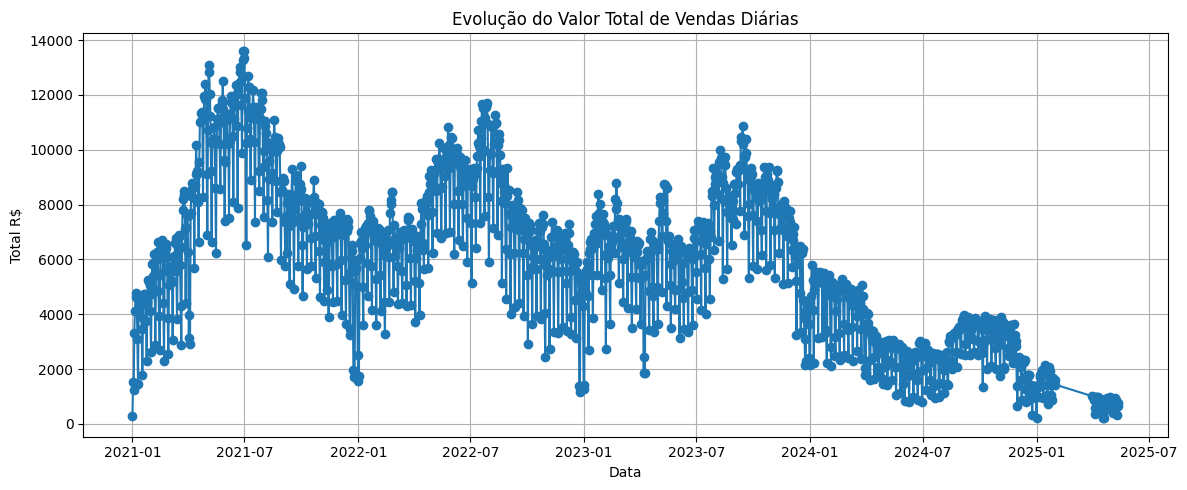

In [25]:
# 018. Série temporal do total de vendas
plt.figure(figsize=(12, 5))
df_grouped = df.groupby('data')['total'].sum()
plt.plot(df_grouped.index, df_grouped.values, marker='o', linestyle='-')
plt.title('Evolução do Valor Total de Vendas Diárias')
plt.xlabel('Data')
plt.ylabel('Total R$')
plt.grid(True)
plt.tight_layout()
plt.show()


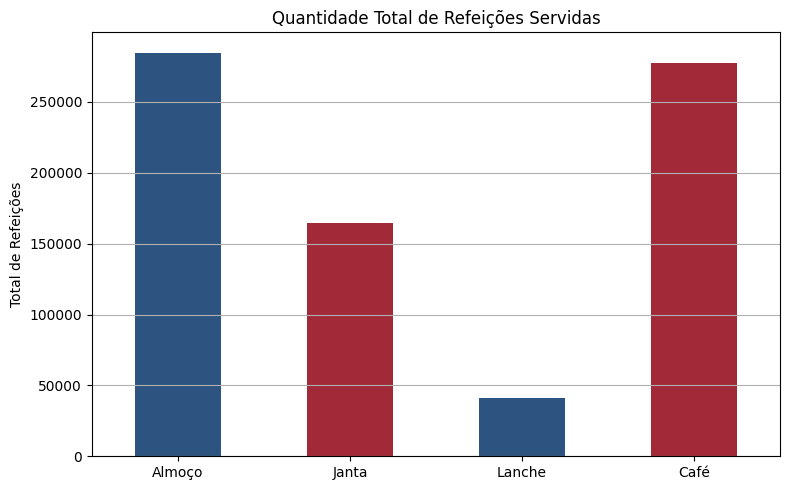

In [26]:
# 019. Comparativo entre tipos de refeição (quantidade total)
qtd_totais = df[['almoco', 'janta', 'lanche', 'cafe']].sum()
qtd_totais.index = ['Almoço', 'Janta', 'Lanche', 'Café']

plt.figure(figsize=(8, 5))
# Para 4 barras, repetir as cores_personalizadas
cores = [cores_personalizadas[i % 2] for i in range(len(qtd_totais))]
qtd_totais.plot(kind='bar', color=cores)
plt.title('Quantidade Total de Refeições Servidas')
plt.ylabel('Total de Refeições')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

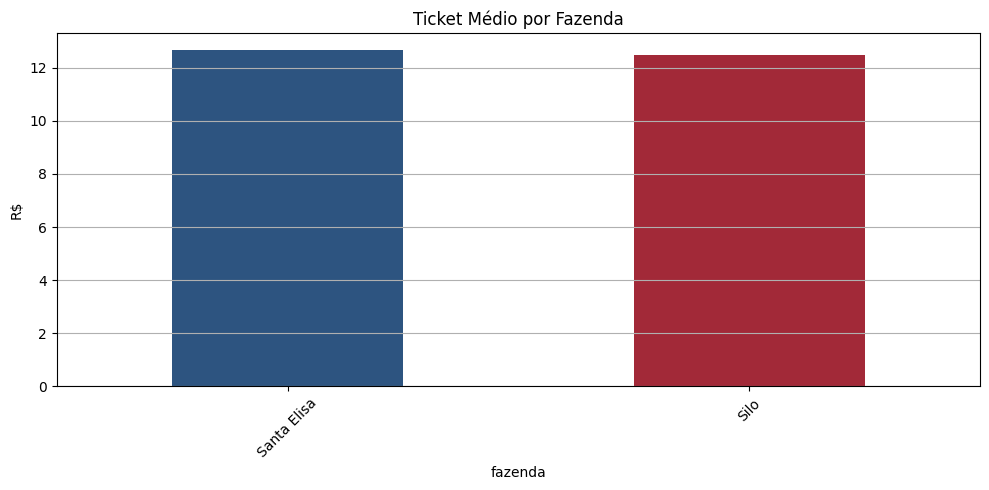

In [27]:
# 020. Ticket médio por fazenda
df['qtd_total'] = df[['almoco', 'janta', 'lanche', 'cafe']].sum(axis=1)
df['ticket_medio'] = df['total'] / df['qtd_total'].replace(0, pd.NA)

ticket_fazenda = df.groupby('fazenda')['ticket_medio'].mean()

plt.figure(figsize=(10, 5))
cores = [cores_personalizadas[i % 2] for i in range(len(ticket_fazenda))]
ticket_fazenda.plot(kind='bar', color=cores)
plt.title('Ticket Médio por Fazenda')
plt.ylabel('R$')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


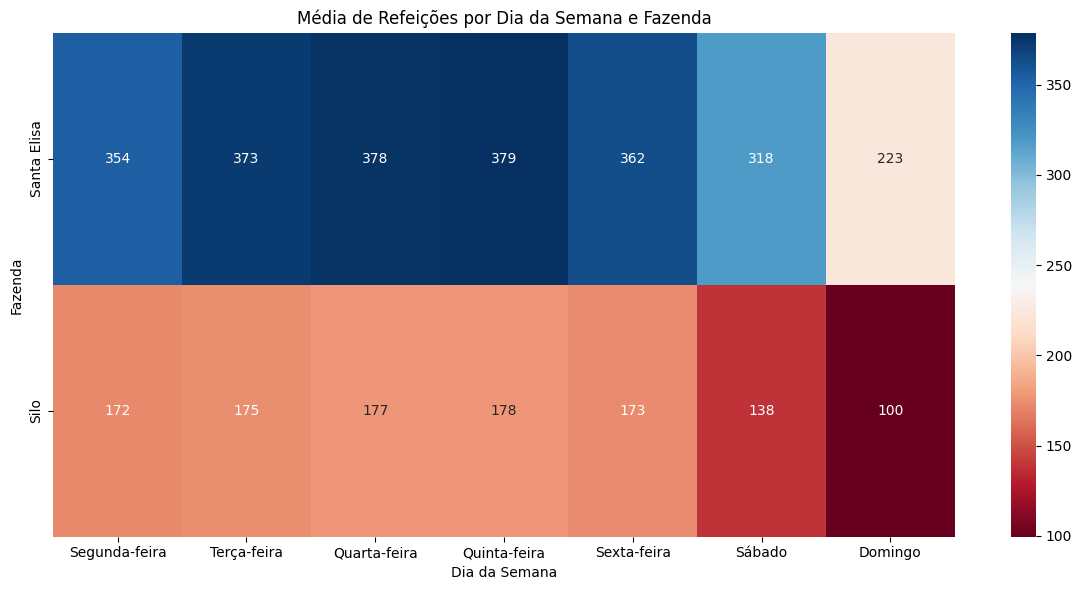

In [28]:
# 021. Calor do volume total de refeições por dia da semana e fazenda
df['dia_semana'] = df['data'].dt.day_name()
df['dia_semana'] = df['dia_semana'].map({
    'Monday': 'Segunda-feira',
    'Tuesday': 'Terça-feira',
    'Wednesday': 'Quarta-feira',
    'Thursday': 'Quinta-feira',
    'Friday': 'Sexta-feira',
    'Saturday': 'Sábado',
    'Sunday': 'Domingo'
})

pivot_table = df.pivot_table(index='fazenda', columns='dia_semana',
                              values='qtd_total', aggfunc='mean')

dias_ordenados_pt = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
pivot_table = pivot_table[dias_ordenados_pt]

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap='RdBu')
plt.title('Média de Refeições por Dia da Semana e Fazenda')
plt.xlabel('Dia da Semana')
plt.ylabel('Fazenda')
plt.tight_layout()
plt.show()
